In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import networkx as nx
import os

In [2]:
def set_network_to_experiment(expNum):
    ### build the network with AS paths
    asGraph = nx.DiGraph()
    pathTable = {}

    for filename in os.listdir("./exp{}/".format(expNum)):
        with open("./exp{}/{}".format(expNum, filename)) as fp:
            try:
                data = json.load(fp)
                txt = data["stdout"].split("\n")
                s = ""
                skiplines = 5
                for line in txt[0:-1]:
                    if skiplines > 0:
                        skiplines -= 1
                    else:
                        s += r"{}".format(line)
                asdata = json.loads(s)
                sourceASN = str(asdata["localAS"])
                for prefix, routeData in asdata["routes"].items():
                    pathStr = routeData[0]["path"]
                    if(len(pathStr) > 0):
                        asList = pathStr.split(" ")
                        asList.insert(0,sourceASN)
                        destASN = str(asList[-1])
                        pathTable[(sourceASN, destASN)] = asList
                        for i in range(len(asList) - 1):
                            asGraph.add_edge(asList[i], asList[i+1])
            except:
                print("failed on: ./exp{}/{}".format(expNum, filename))

    ### add end users
    asGraph.add_edge("10.0.12.100", "64512")
    asGraph.add_edge("64512", "10.0.12.100")
    asGraph.add_edge("10.0.13.100", "64513")
    asGraph.add_edge("64513", "10.0.13.100")
    asGraph.add_edge("10.0.21.100", "64521")
    asGraph.add_edge("64521", "10.0.21.100")
    
    return asGraph, pathTable

# Start with the default network

In [3]:
asGraph, pathTable = set_network_to_experiment(0)

failed on: ./exp0/10.0.21.100.as
failed on: ./exp0/10.0.13.100.as
failed on: ./exp0/10.0.12.100.as


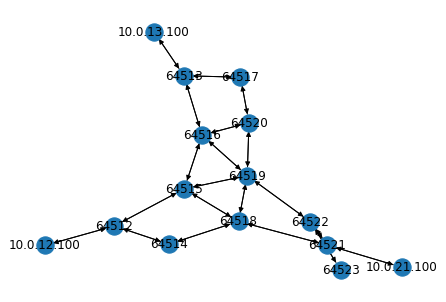

In [4]:
nx.draw(asGraph, with_labels=True)

In [5]:
### define nodes:
censorNodes = {"64518", "64519", "64513"}
endHosts = {"10.0.12.100","10.0.13.100","10.0.21.100"}
endHostASNs = {"10.0.12.100":"64512","10.0.13.100":"64513","10.0.21.100":"64521"}

In [6]:
### use a poisson clock to send packets at each timestep
timesteps = 100
packetsIntercepted = []
packetsLost = []
for t in range(timesteps):
    packetsIntercepted.append(0)
    packetsLost.append(0)
    for host in endHosts:
        numPackets = np.random.poisson(lam=50.0)
        notMeHosts = endHosts - {host}
        for p in range(numPackets):
            dest = np.random.choice(list(notMeHosts))
            ### follow the path
            sourceASN = endHostASNs[host]
            destASN = endHostASNs[dest]
            try:
                path = pathTable[(sourceASN, destASN)]
                for asn in path:
                    if asn in censorNodes:
                        packetsIntercepted[-1] += 1
            except:
                packetsLost[-1] += 1

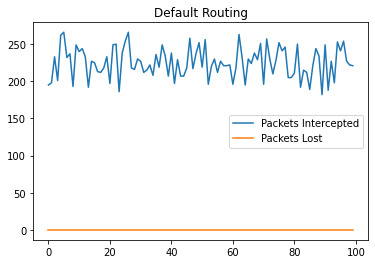

In [7]:
plt.figure()
plt.plot(packetsIntercepted,label="Packets Intercepted")
plt.plot(packetsLost,label="Packets Lost")
plt.legend()
plt.title("Default Routing")
plt.show()

# Now let's do some poisoning

In [8]:
asGraph, pathTable = set_network_to_experiment(1)

failed on: ./exp1/10.0.21.100.as
failed on: ./exp1/10.0.13.100.as
failed on: ./exp1/10.0.12.100.as


In [9]:
for t in range(timesteps):
    packetsIntercepted.append(0)
    packetsLost.append(0)
    for host in endHosts:
        numPackets = np.random.poisson(lam=50.0)
        notMeHosts = endHosts - {host}
        for p in range(numPackets):
            dest = np.random.choice(list(notMeHosts))
            ### follow the path
            sourceASN = endHostASNs[host]
            destASN = endHostASNs[dest]
            try:
                path = pathTable[(sourceASN, destASN)]
                for asn in path:
                    if asn in censorNodes:
                        packetsIntercepted[-1] += 1
            except:
                packetsLost[-1] += 1

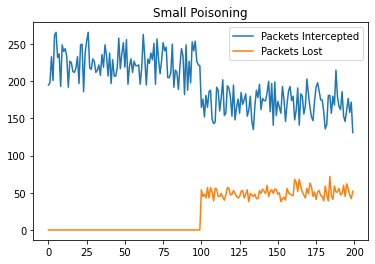

In [10]:
plt.figure()
plt.plot(packetsIntercepted,label="Packets Intercepted")
plt.plot(packetsLost,label="Packets Lost")
plt.legend()
plt.title("Small Poisoning")
plt.show()